In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import time
import warnings
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
train_data_dir = 'training_set/training_set'
test_data_dir = 'test_set/test_set'

In [3]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:] + dogs[:]
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import shuffle, seed; seed(9); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] 
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im) 
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [4]:
data = CatsDogs(train_data_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0')


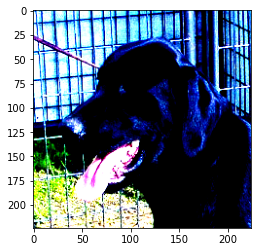

In [5]:
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [6]:
#VGG-19 with Adam optimizer
def get_model():
    model = models.vgg19(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(512, 128),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(128, 1),
                                     nn.Sigmoid()
                                    )
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [7]:
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [8]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [9]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [10]:
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [11]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [12]:
train_losses_adam, train_accuracies_adam = [], []
val_accuracies_adam = []
start = time.time()
for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses_adam, train_epoch_accuracies_adam = [], []
    val_epoch_accuracies_adam = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses_adam.append(batch_loss) 
    train_epoch_loss_adam = np.array(train_epoch_losses_adam).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies_adam.extend(is_correct)
    train_epoch_accuracy_adam = np.mean(train_epoch_accuracies_adam)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies_adam.extend(val_is_correct)
    val_epoch_accuracy_adam = np.mean(val_epoch_accuracies_adam)

    train_losses_adam.append(train_epoch_loss_adam)
    train_accuracies_adam.append(train_epoch_accuracy_adam)
    val_accuracies_adam.append(val_epoch_accuracy_adam)
    print('seconds: ', time.time()-start)

 epoch 1/5
seconds:  340.3235664367676
 epoch 2/5
seconds:  467.6672251224518
 epoch 3/5
seconds:  592.5869274139404
 epoch 4/5
seconds:  718.103536605835
 epoch 5/5
seconds:  841.3633630275726


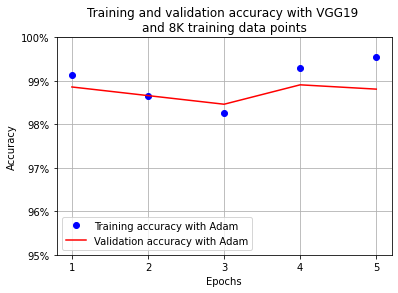

In [13]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies_adam, 'bo', label='Training accuracy with Adam')
plt.plot(epochs, val_accuracies_adam, 'r', label='Validation accuracy with Adam')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG19 \nand 8K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [14]:
#VGG-19 with SGD optimizer
def get_model():
    model = models.vgg19(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(512, 128),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(128, 1),
                                     nn.Sigmoid()
                                    )
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [15]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [16]:
train_losses_SGD, train_accuracies_SGD = [], []
val_accuracies_SGD = []
start = time.time()
for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses_SGD, train_epoch_accuracies_SGD = [], []
    val_epoch_accuracies_SGD = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses_SGD.append(batch_loss) 
    train_epoch_loss_SGD = np.array(train_epoch_losses_SGD).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies_SGD.extend(is_correct)
    train_epoch_accuracy_SGD = np.mean(train_epoch_accuracies_SGD)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies_SGD.extend(val_is_correct)
    val_epoch_accuracy_SGD = np.mean(val_epoch_accuracies_SGD)

    train_losses_SGD.append(train_epoch_loss_SGD)
    train_accuracies_SGD.append(train_epoch_accuracy_SGD)
    val_accuracies_SGD.append(val_epoch_accuracy_SGD)
    print('seconds: ', time.time()-start)

 epoch 1/5
seconds:  123.78043389320374
 epoch 2/5
seconds:  247.42005133628845
 epoch 3/5
seconds:  371.5959441661835
 epoch 4/5
seconds:  494.9552414417267
 epoch 5/5
seconds:  619.0970463752747


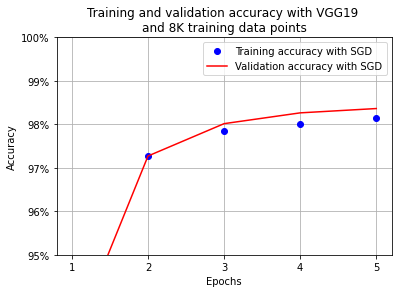

In [17]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies_SGD, 'bo', label='Training accuracy with SGD')
plt.plot(epochs, val_accuracies_SGD, 'r', label='Validation accuracy with SGD')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG19 \nand 8K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [18]:
#VGG-19 with RMSPropagation optimizer
def get_model():
    model = models.vgg19(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(512, 128),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(128, 1),
                                     nn.Sigmoid()
                                    )
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses_rmsprop, train_accuracies_rmsprop = [], []
val_accuracies_rmsprop = []
start = time.time()
for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses_rmsprop, train_epoch_accuracies_rmsprop = [], []
    val_epoch_accuracies_rmsprop = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses_rmsprop.append(batch_loss) 
    train_epoch_loss_rmsprop = np.array(train_epoch_losses_rmsprop).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies_rmsprop.extend(is_correct)
    train_epoch_accuracy_rmsprop = np.mean(train_epoch_accuracies_rmsprop)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies_rmsprop.extend(val_is_correct)
    val_epoch_accuracy_rmsprop = np.mean(val_epoch_accuracies_rmsprop)

    train_losses_rmsprop.append(train_epoch_loss_rmsprop)
    train_accuracies_rmsprop.append(train_epoch_accuracy_rmsprop)
    val_accuracies_rmsprop.append(val_epoch_accuracy_rmsprop)
    print('seconds: ', time.time()-start)

 epoch 1/5
seconds:  124.09525918960571
 epoch 2/5
seconds:  244.53813123703003
 epoch 3/5
seconds:  365.36536478996277
 epoch 4/5
seconds:  486.62222599983215
 epoch 5/5
seconds:  607.1186056137085


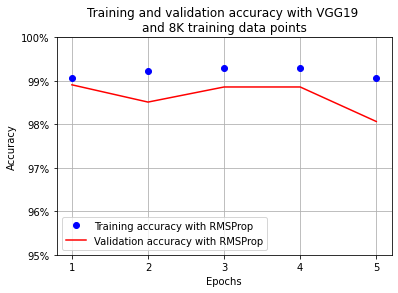

In [19]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies_rmsprop, 'bo', label='Training accuracy with RMSProp')
plt.plot(epochs, val_accuracies_rmsprop, 'r', label='Validation accuracy with RMSProp')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG19 \nand 8K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

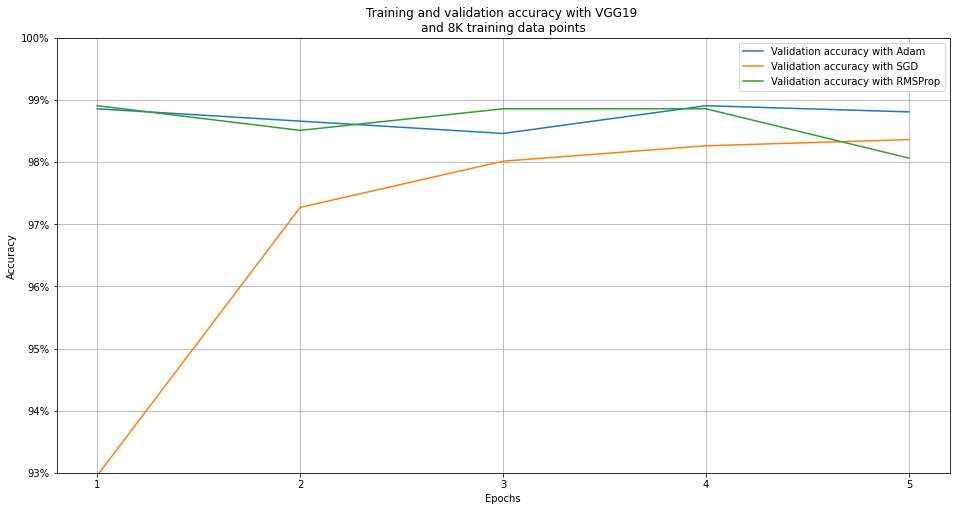

In [29]:
epochs = np.arange(5)+1
plt.figure(figsize=(16,8))
plt.plot(epochs, val_accuracies_adam, label='Validation accuracy with Adam')
plt.plot(epochs, val_accuracies_SGD, label='Validation accuracy with SGD')
plt.plot(epochs, val_accuracies_rmsprop, label='Validation accuracy with RMSProp')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG19 \nand 8K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.93,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()